In [10]:
from PIL import Image, ImageOps, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- Глобальные переменные (как у препода) ---
original_img = None         # исходное изображение (PIL)
binary_img = None           # бинаризованное изображение (PIL)
preview_max_size = 300      # размер превью по стороне
trajectory_mode = "horizontal"  # horizontal / vertical / snake


# --- Вспомогательное отображение в Colab ---
def show_image(img, title=""):
    plt.figure(figsize=(4, 4))
    if img.mode == "L":
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


# ================= Загрузка изображения =================
def load_image():
    global original_img, binary_img
    uploaded = files.upload()
    if not uploaded:
        print("Файл не выбран")
        return
    name = list(uploaded.keys())[0]
    img = Image.open(name).convert("RGB")
    original_img = img.copy()
    binary_img = None

    # уменьшаем для превью, как в методичке
    preview = img.copy()
    preview.thumbnail((preview_max_size, preview_max_size))
    show_image(preview, "Оригинал")

    print("Изображение загружено:", name)


# ================= Бинаризация =================
def binarize_image(threshold=128):
    global original_img, binary_img
    if original_img is None:
        print("Сначала загрузите изображение")
        return

    thr = max(0, min(255, int(threshold)))
    gray = original_img.convert("L")
    gray = ImageOps.autocontrast(gray)

    # >thr -> белый, иначе чёрный
    binary_img = gray.point(lambda p: 255 if p > thr else 0).convert("1")

    preview = binary_img.convert("L")
    preview.thumbnail((preview_max_size, preview_max_size))
    show_image(preview, f"Бинаризованное (threshold={thr})")


# ================= Генерация G-кода =================
def generate_gcode_from_image(
    img,
    pixel_size_mm=0.1,
    feed=1000,
    z_safe=5.0,
    z_work=-1.0,
    mode="horizontal",
    spindle_power=1000
):
    """
    img – бинарное PIL '1'
    mode: horizontal / vertical / snake
    возвращает (gcode_text, length_mm)
    """
    img_bin = img.convert("1")
    arr = np.array(img_bin, dtype=np.uint8)
    h, w = arr.shape

    gcode_lines = []
    gcode_lines.append("(Сгенерировано в Google Colab)")
    gcode_lines.append("G21")
    gcode_lines.append("G90")
    gcode_lines.append(f"F{feed}")
    gcode_lines.append(f"G0 Z{z_safe:.3f}")

    length_xy = 0.0

    def draw_segment_horizontal(x_start_px, x_end_px, y_px):
        nonlocal length_xy
        x1 = x_start_px * pixel_size_mm
        x2 = x_end_px * pixel_size_mm
        y = (h - y_px) * pixel_size_mm

        gcode_lines.append(f"G0 Z{z_safe:.3f}")
        gcode_lines.append(f"G0 X{x1:.3f} Y{y:.3f}")
        gcode_lines.append(f"M3 S{spindle_power}")
        gcode_lines.append("G4 P0.2")
        gcode_lines.append(f"G1 Z{z_work:.3f} F{feed}")
        gcode_lines.append(f"G1 X{x2:.3f} Y{y:.3f} F{feed}")
        length_xy += abs(x2 - x1)
        gcode_lines.append(f"G0 Z{z_safe:.3f}")
        gcode_lines.append("M5")

    def draw_segment_vertical(x_px, y_start_px, y_end_px):
        nonlocal length_xy
        x = x_px * pixel_size_mm
        y1 = (h - y_start_px) * pixel_size_mm
        y2 = (h - y_end_px) * pixel_size_mm

        gcode_lines.append(f"G0 Z{z_safe:.3f}")
        gcode_lines.append(f"G0 X{x:.3f} Y{y1:.3f}")
        gcode_lines.append(f"M3 S{spindle_power}")
        gcode_lines.append("G4 P0.2")
        gcode_lines.append(f"G1 Z{z_work:.3f} F{feed}")
        gcode_lines.append(f"G1 X{x:.3f} Y{y2:.3f} F{feed}")
        length_xy += abs(y2 - y1)
        gcode_lines.append(f"G0 Z{z_safe:.3f}")
        gcode_lines.append("M5")

    # --- обход изображения ---
    if mode in ("horizontal", "snake"):
        for y in range(h):
            if mode == "snake" and (y % 2 == 1):
                x_range = range(w - 1, -1, -1)
            else:
                x_range = range(w)

            row = arr[y]
            run_start = None
            prev_x = None

            for x in x_range:
                is_black = (row[x] == 0)  # 0 = чёрный
                if is_black and run_start is None:
                    run_start = x
                elif not is_black and run_start is not None:
                    run_end = prev_x
                    draw_segment_horizontal(run_start, run_end, y)
                    run_start = None
                prev_x = x

            if run_start is not None:
                run_end = prev_x
                draw_segment_horizontal(run_start, run_end, y)

    elif mode == "vertical":
        for x in range(w):
            col = arr[:, x]
            run_start = None
            prev_y = None

            for y in range(h):
                is_black = (col[y] == 0)
                if is_black and run_start is None:
                    run_start = y
                elif not is_black and run_start is not None:
                    run_end = prev_y
                    draw_segment_vertical(x, run_start, run_end)
                    run_start = None
                prev_y = y

            if run_start is not None:
                run_end = prev_y
                draw_segment_vertical(x, run_start, run_end)

    gcode_lines.append("M5")
    gcode_lines.append(f"G0 Z{z_safe:.3f}")
    gcode_lines.append("G0 X0.000 Y0.000")
    gcode_lines.append("M2")
    gcode_lines.append(f"(Длина траектории по XY = {length_xy:.2f} мм)")

    return "\n".join(gcode_lines), length_xy


# ================= Предпросмотр траектории =================
def build_toolpath_preview(img, max_size=300, mode="horizontal"):
    img_bin = img.convert("1")
    arr = np.array(img_bin, dtype=np.uint8)
    h, w = arr.shape

    vis = Image.new("RGB", (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(vis)

    if mode in ("horizontal", "snake"):
        for y in range(h):
            if mode == "snake" and (y % 2 == 1):
                x_range = range(w - 1, -1, -1)
            else:
                x_range = range(w)
            row = arr[y]
            run_start = None
            prev_x = None
            for x in x_range:
                is_black = (row[x] == 0)
                if is_black and run_start is None:
                    run_start = x
                elif not is_black and run_start is not None:
                    run_end = prev_x
                    draw.line([(run_start, y), (run_end, y)], fill=(255, 0, 0))
                    run_start = None
                prev_x = x
            if run_start is not None:
                run_end = prev_x
                draw.line([(run_start, y), (run_end, y)], fill=(255, 0, 0))

    elif mode == "vertical":
        for x in range(w):
            col = arr[:, x]
            run_start = None
            prev_y = None
            for y in range(h):
                is_black = (col[y] == 0)
                if is_black and run_start is None:
                    run_start = y
                elif not is_black and run_start is not None:
                    run_end = prev_y
                    draw.line([(x, run_start), (x, run_end)], fill=(255, 0, 0))
                    run_start = None
                prev_y = y
            if run_start is not None:
                run_end = prev_y
                draw.line([(x, run_start), (x, run_end)], fill=(255, 0, 0))

    max_side = max(w, h)
    scale = 1.0
    if max_side > max_size:
        scale = max_size / max_side
    if scale != 1.0:
        new_size = (int(w * scale), int(h * scale))
        vis = vis.resize(new_size, Image.NEAREST)
    return vis


def preview_toolpath():
    global binary_img, trajectory_mode
    if binary_img is None:
        print("Сначала бинаризуйте изображение")
        return
    img = build_toolpath_preview(binary_img, max_size=preview_max_size, mode=trajectory_mode)
    show_image(img, f"Траектория ({trajectory_mode})")


# ================= Сохранение G-кода (аналог save_gcode) =================
def save_gcode():
    global binary_img, trajectory_mode
    if binary_img is None:
        print("Сначала бинаризуйте изображение")
        return

    # параметры как в методичке, но через input()
    try:
        px = input("Размер пикселя, мм [0.1]: ").strip()
        pixel = float(px.replace(",", ".")) if px else 0.1
    except ValueError:
        pixel = 0.1

    try:
        f = input("Feed (F), мм/мин [1000]: ").strip()
        feed = int(f) if f else 1000
    except ValueError:
        feed = 1000

    try:
        zs = input("Z safe [5.0]: ").strip()
        z_safe = float(zs.replace(",", ".")) if zs else 5.0
    except ValueError:
        z_safe = 5.0

    try:
        zw = input("Z work [-1.0]: ").strip()
        z_work = float(zw.replace(",", ".")) if zw else -1.0
    except ValueError:
        z_work = -1.0

    mode_raw = input("Режим траектории (h=horizontal, v=vertical, s=snake) [h]: ").strip().lower()
    if mode_raw == "v":
        trajectory_mode = "vertical"
    elif mode_raw == "s":
        trajectory_mode = "snake"
    else:
        trajectory_mode = "horizontal"

    gcode_text, length_mm = generate_gcode_from_image(
        binary_img,
        pixel_size_mm=pixel,
        feed=feed,
        z_safe=z_safe,
        z_work=z_work,
        mode=trajectory_mode
    )

    fname = "output.gcode"
    with open(fname, "w", encoding="utf-8") as f:
        f.write(gcode_text)

    print("G-код сохранён в файл:", fname)
    print("Длина траектории по XY:", f"{length_mm:.2f}", "мм")
    files.download(fname)


# ================= Общий запуск (как будто GUI, но для Colab) =================
def run_lab():
    print("ШАГ 1: загрузите изображение")
    load_image()

    thr_str = input("Порог бинаризации (0..255) [128]: ").strip()
    try:
        thr = int(thr_str) if thr_str else 128
    except ValueError:
        thr = 128
    binarize_image(thr)

    mode_raw = input("Предпросмотр траектории? (h=horizontal, v=vertical, s=snake, Enter=пропустить): ").strip().lower()
    if mode_raw in ("h", "v", "s"):
        global trajectory_mode
        if mode_raw == "v":
            trajectory_mode = "vertical"
        elif mode_raw == "s":
            trajectory_mode = "snake"
        else:
            trajectory_mode = "horizontal"
        preview_toolpath()

    print("Теперь будут заданы параметры G-кода и файл сохранится.")
    save_gcode()


print("Код загружен. Во второй ячейке вызови: run_lab()")

Код загружен. Во второй ячейке вызови: run_lab()


In [15]:
from PIL import Image, ImageOps, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- Глобальные переменные ---
original_img = None
binary_img = None
preview_max_size = 300
trajectory_mode = "horizontal"


# --- Вспомогательное отображение в Colab ---
def show_image(img, title=""):
    plt.figure(figsize=(4, 4))
    if img.mode == "L":
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


# ================= Загрузка изображения =================
def load_image():
    global original_img, binary_img
    uploaded = files.upload()
    if not uploaded:
        print("Файл не выбран")
        return
    name = list(uploaded.keys())[0]
    img = Image.open(name).convert("RGB")
    original_img = img.copy()
    binary_img = None

    preview = img.copy()
    preview.thumbnail((preview_max_size, preview_max_size))
    show_image(preview, "Оригинал")

    print("Изображение загружено:", name)


# ================= Бинаризация =================
def binarize_image(threshold=128):
    global original_img, binary_img
    if original_img is None:
        print("Сначала загрузите изображение")
        return

    thr = max(0, min(255, int(threshold)))
    gray = original_img.convert("L")
    gray = ImageOps.autocontrast(gray)

    binary_img = gray.point(lambda p: 255 if p > thr else 0).convert("1")

    preview = binary_img.convert("L")
    preview.thumbnail((preview_max_size, preview_max_size))
    show_image(preview, f"Бинаризованное (threshold={thr})")


# ================= Генерация G-кода =================
def generate_gcode_from_image(
    img,
    pixel_size_mm=0.1,
    feed=1000,
    z_safe=5.0,
    z_work=-1.0,
    mode="horizontal",
    spindle_power=1000,
    pause_seconds=0.2,
    use_laser=False
):
    """
    img – бинарное PIL '1'
    mode: horizontal / vertical / snake
    spindle_power: мощность шпинделя (для M3 S...)
    pause_seconds: пауза перед началом резания (G4 P...)
    use_laser: True для лазера, False для шпинделя
    возвращает (gcode_text, length_mm, stats)
    """
    img_bin = img.convert("1")
    arr = np.array(img_bin, dtype=np.uint8)
    h, w = arr.shape

    gcode_lines = []
    gcode_lines.append("(Сгенерировано в Google Colab)")
    gcode_lines.append("G21 (миллиметры)")
    gcode_lines.append("G90 (абсолютные координаты)")
    gcode_lines.append(f"F{feed} (скорость подачи)")
    gcode_lines.append(f"G0 Z{z_safe:.3f} (поднятие в безопасную высоту)")

    # Статистика
    stats = {
        "total_segments": 0,
        "horizontal_segments": 0,
        "vertical_segments": 0,
        "line_count": 0
    }

    length_xy = 0.0

    def draw_segment_horizontal(x_start_px, x_end_px, y_px):
        nonlocal length_xy
        x1 = x_start_px * pixel_size_mm
        x2 = x_end_px * pixel_size_mm
        y = (h - y_px) * pixel_size_mm

        gcode_lines.append(f"G0 Z{z_safe:.3f}")
        gcode_lines.append(f"G0 X{x1:.3f} Y{y:.3f}")

        if use_laser:
            gcode_lines.append("M106 (включение лазера)")  # Для лазера в Marlin
        else:
            gcode_lines.append(f"M3 S{spindle_power} (включение шпинделя)")

        gcode_lines.append(f"G4 P{pause_seconds} (пауза)")
        gcode_lines.append(f"G1 Z{z_work:.3f} F{feed}")
        gcode_lines.append(f"G1 X{x2:.3f} Y{y:.3f} F{feed}")

        length_xy += abs(x2 - x1)

        if use_laser:
            gcode_lines.append("M107 (выключение лазера)")
        else:
            gcode_lines.append("M5 (выключение шпинделя)")

        gcode_lines.append(f"G0 Z{z_safe:.3f}")

        stats["total_segments"] += 1
        stats["horizontal_segments"] += 1

    def draw_segment_vertical(x_px, y_start_px, y_end_px):
        nonlocal length_xy
        x = x_px * pixel_size_mm
        y1 = (h - y_start_px) * pixel_size_mm
        y2 = (h - y_end_px) * pixel_size_mm

        gcode_lines.append(f"G0 Z{z_safe:.3f}")
        gcode_lines.append(f"G0 X{x:.3f} Y{y1:.3f}")

        if use_laser:
            gcode_lines.append("M106 (включение лазера)")
        else:
            gcode_lines.append(f"M3 S{spindle_power} (включение шпинделя)")

        gcode_lines.append(f"G4 P{pause_seconds} (пауза)")
        gcode_lines.append(f"G1 Z{z_work:.3f} F{feed}")
        gcode_lines.append(f"G1 X{x:.3f} Y{y2:.3f} F{feed}")

        length_xy += abs(y2 - y1)

        if use_laser:
            gcode_lines.append("M107 (выключение лазера)")
        else:
            gcode_lines.append("M5 (выключение шпинделя)")

        gcode_lines.append(f"G0 Z{z_safe:.3f}")

        stats["total_segments"] += 1
        stats["vertical_segments"] += 1

    # --- обход изображения ---
    if mode in ("horizontal", "snake"):
        for y in range(h):
            if mode == "snake" and (y % 2 == 1):
                x_range = range(w - 1, -1, -1)
            else:
                x_range = range(w)

            row = arr[y]
            run_start = None
            prev_x = None

            for x in x_range:
                is_black = (row[x] == 0)  # 0 = чёрный
                if is_black and run_start is None:
                    run_start = x
                elif not is_black and run_start is not None:
                    run_end = prev_x
                    draw_segment_horizontal(run_start, run_end, y)
                    run_start = None
                prev_x = x

            if run_start is not None:
                run_end = prev_x
                draw_segment_horizontal(run_start, run_end, y)

    elif mode == "vertical":
        for x in range(w):
            col = arr[:, x]
            run_start = None
            prev_y = None

            for y in range(h):
                is_black = (col[y] == 0)
                if is_black and run_start is None:
                    run_start = y
                elif not is_black and run_start is not None:
                    run_end = prev_y
                    draw_segment_vertical(x, run_start, run_end)
                    run_start = None
                prev_y = y

            if run_start is not None:
                run_end = prev_y
                draw_segment_vertical(x, run_start, run_end)

    # Завершающие команды
    if use_laser:
        gcode_lines.append("M107 (выключение лазера)")
    else:
        gcode_lines.append("M5 (выключение шпинделя)")

    gcode_lines.append(f"G0 Z{z_safe:.3f}")
    gcode_lines.append("G0 X0.000 Y0.000")
    gcode_lines.append("M2 (конец программы)")

    # Статистика
    stats["line_count"] = len(gcode_lines)
    stats["total_length_mm"] = length_xy

    # Информация о режиме
    gcode_lines.append(f"(Режим траектории: {mode})")
    gcode_lines.append(f"(Размер пикселя: {pixel_size_mm} мм)")
    gcode_lines.append(f"(Размер изображения: {w} x {h} пикселей)")
    gcode_lines.append(f"(Общий путь резания по XY: {length_xy:.2f} мм)")
    gcode_lines.append(f"(Количество сегментов: {stats['total_segments']})")

    return "\n".join(gcode_lines), length_xy, stats


# ================= Предпросмотр траектории =================
def build_toolpath_preview(img, max_size=300, mode="horizontal"):
    img_bin = img.convert("1")
    arr = np.array(img_bin, dtype=np.uint8)
    h, w = arr.shape

    vis = Image.new("RGB", (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(vis)

    if mode in ("horizontal", "snake"):
        for y in range(h):
            if mode == "snake" and (y % 2 == 1):
                x_range = range(w - 1, -1, -1)
            else:
                x_range = range(w)
            row = arr[y]
            run_start = None
            prev_x = None
            for x in x_range:
                is_black = (row[x] == 0)
                if is_black and run_start is None:
                    run_start = x
                elif not is_black and run_start is not None:
                    run_end = prev_x
                    draw.line([(run_start, y), (run_end, y)], fill=(255, 0, 0))
                    run_start = None
                prev_x = x
            if run_start is not None:
                run_end = prev_x
                draw.line([(run_start, y), (run_end, y)], fill=(255, 0, 0))

    elif mode == "vertical":
        for x in range(w):
            col = arr[:, x]
            run_start = None
            prev_y = None
            for y in range(h):
                is_black = (col[y] == 0)
                if is_black and run_start is None:
                    run_start = y
                elif not is_black and run_start is not None:
                    run_end = prev_y
                    draw.line([(x, run_start), (x, run_end)], fill=(255, 0, 0))
                    run_start = None
                prev_y = y
            if run_start is not None:
                run_end = prev_y
                draw.line([(x, run_start), (x, run_end)], fill=(255, 0, 0))

    max_side = max(w, h)
    scale = 1.0
    if max_side > max_size:
        scale = max_size / max_side
    if scale != 1.0:
        new_size = (int(w * scale), int(h * scale))
        vis = vis.resize(new_size, Image.NEAREST)
    return vis


def preview_toolpath():
    global binary_img, trajectory_mode
    if binary_img is None:
        print("Сначала бинаризуйте изображение")
        return
    img = build_toolpath_preview(binary_img, max_size=preview_max_size, mode=trajectory_mode)
    show_image(img, f"Траектория ({trajectory_mode})")


# ================= Сравнение разных режимов траектории =================
def compare_trajectory_modes():
    global binary_img
    if binary_img is None:
        print("Сначала бинаризуйте изображение")
        return

    print("\n=== Сравнение разных режимов траектории ===")

    # Параметры по умолчанию
    params = {
        "pixel_size_mm": 0.1,
        "feed": 1000,
        "z_safe": 5.0,
        "z_work": -1.0,
        "spindle_power": 1000,
        "pause_seconds": 0.2,
        "use_laser": False
    }

    results = []

    for mode in ["horizontal", "vertical", "snake"]:
        gcode_text, length_mm, stats = generate_gcode_from_image(
            binary_img,
            pixel_size_mm=params["pixel_size_mm"],
            feed=params["feed"],
            z_safe=params["z_safe"],
            z_work=params["z_work"],
            mode=mode,
            spindle_power=params["spindle_power"],
            pause_seconds=params["pause_seconds"],
            use_laser=params["use_laser"]
        )

        results.append({
            "mode": mode,
            "length_mm": length_mm,
            "segments": stats["total_segments"],
            "lines": stats["line_count"]
        })

        print(f"\nРежим: {mode}")
        print(f"  Длина траектории: {length_mm:.2f} мм")
        print(f"  Количество сегментов: {stats['total_segments']}")
        print(f"  Количество строк G-кода: {stats['line_count']}")

    # Находим оптимальный режим
    best_by_length = min(results, key=lambda x: x["length_mm"])
    best_by_segments = min(results, key=lambda x: x["segments"])

    print("\n=== ИТОГИ ===")
    print(f"Оптимальный режим по длине траектории: {best_by_length['mode']} ({best_by_length['length_mm']:.2f} мм)")
    print(f"Оптимальный режим по количеству сегментов: {best_by_segments['mode']} ({best_by_segments['segments']} сегментов)")

    return results


# ================= Сохранение G-кода =================
def save_gcode():
    global binary_img, trajectory_mode
    if binary_img is None:
        print("Сначала бинаризуйте изображение")
        return

    print("\n=== Параметры G-кода ===")

    # Получение параметров от пользователя
    try:
        px = input("Размер пикселя, мм [0.1]: ").strip()
        pixel = float(px.replace(",", ".")) if px else 0.1
    except ValueError:
        pixel = 0.1

    try:
        f = input("Feed (F), мм/мин [1000]: ").strip()
        feed = int(f) if f else 1000
    except ValueError:
        feed = 1000

    try:
        zs = input("Z safe, мм [5.0]: ").strip()
        z_safe = float(zs.replace(",", ".")) if zs else 5.0
    except ValueError:
        z_safe = 5.0

    try:
        zw = input("Z work, мм [-1.0]: ").strip()
        z_work = float(zw.replace(",", ".")) if zw else -1.0
    except ValueError:
        z_work = -1.0

    mode_raw = input("Режим траектории (h=horizontal, v=vertical, s=snake) [h]: ").strip().lower()
    if mode_raw == "v":
        trajectory_mode = "vertical"
    elif mode_raw == "s":
        trajectory_mode = "snake"
    else:
        trajectory_mode = "horizontal"

    # Параметры управления инструментом
    tool_type = input("Тип инструмента (s=шпиндель, l=лазер) [s]: ").strip().lower()
    use_laser = (tool_type == "l")

    if use_laser:
        spindle_power = 255  # Максимальная мощность для лазера
    else:
        try:
            sp = input("Мощность шпинделя (S), 0-1000 [1000]: ").strip()
            spindle_power = int(sp) if sp else 1000
        except ValueError:
            spindle_power = 1000

    try:
        pause = input("Пауза перед резанием, сек [0.2]: ").strip()
        pause_seconds = float(pause.replace(",", ".")) if pause else 0.2
    except ValueError:
        pause_seconds = 0.2

    # Генерация G-кода
    gcode_text, length_mm, stats = generate_gcode_from_image(
        binary_img,
        pixel_size_mm=pixel,
        feed=feed,
        z_safe=z_safe,
        z_work=z_work,
        mode=trajectory_mode,
        spindle_power=spindle_power,
        pause_seconds=pause_seconds,
        use_laser=use_laser
    )

    # Сохранение файла
    fname = "output.gcode"
    with open(fname, "w", encoding="utf-8") as f:
        f.write(gcode_text)

    print("\n=== Результаты ===")
    print(f"Режим траектории: {trajectory_mode}")
    print(f"Инструмент: {'Лазер' if use_laser else 'Шпиндель'}")
    if not use_laser:
        print(f"Мощность шпинделя: S{spindle_power}")
    print(f"Пауза перед резанием: G4 P{pause_seconds}")
    print(f"Длина траектории резания: {length_mm:.2f} мм")
    print(f"Количество сегментов: {stats['total_segments']}")
    print(f"Количество строк G-кода: {stats['line_count']}")
    print(f"\nG-код сохранён в файл: {fname}")

    files.download(fname)

    return length_mm, stats


# ================= Общий запуск =================
def run_lab():
    print("=== Генератор G-кода для гравировки изображений ===")

    # Шаг 1: Загрузка изображения
    print("\nШАГ 1: Загрузка изображения")
    load_image()

    # Шаг 2: Бинаризация
    thr_str = input("\nПорог бинаризации (0..255) [128]: ").strip()
    try:
        thr = int(thr_str) if thr_str else 128
    except ValueError:
        thr = 128
    binarize_image(thr)

    # Шаг 3: Предпросмотр траектории
    mode_raw = input("\nПредпросмотр траектории? (h=horizontal, v=vertical, s=snake, c=сравнение всех режимов, Enter=пропустить): ").strip().lower()

    if mode_raw == "c":
        compare_trajectory_modes()
        mode_raw = input("\nВыберите режим для предпросмотра (h/v/s, Enter=пропустить): ").strip().lower()

    if mode_raw in ("h", "v", "s"):
        global trajectory_mode
        if mode_raw == "v":
            trajectory_mode = "vertical"
        elif mode_raw == "s":
            trajectory_mode = "snake"
        else:
            trajectory_mode = "horizontal"
        preview_toolpath()

    # Шаг 4: Генерация и сохранение G-кода
    print("\nШАГ 4: Генерация и сохранение G-кода")
    save_gcode()

    print("\n=== Процесс завершён ===")


print("Код загружен. Для запуска во второй ячейке вызовите: run_lab()")

Код загружен. Для запуска во второй ячейке вызовите: run_lab()


=== Генератор G-кода для гравировки изображений ===

ШАГ 1: Загрузка изображения


Saving милый вислоухий котик.jpg to милый вислоухий котик (5).jpg


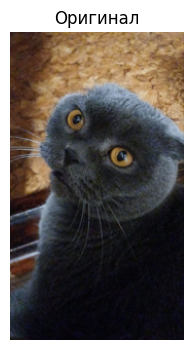

Изображение загружено: милый вислоухий котик (5).jpg

Порог бинаризации (0..255) [128]: 200


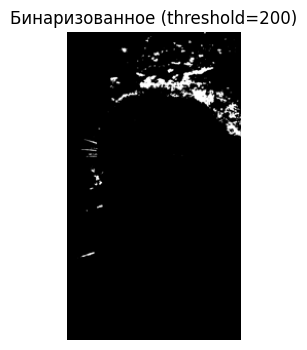


Предпросмотр траектории? (h=horizontal, v=vertical, s=snake, c=сравнение всех режимов, Enter=пропустить): 

ШАГ 4: Генерация и сохранение G-кода

=== Параметры G-кода ===
Размер пикселя, мм [0.1]: 0.1
Feed (F), мм/мин [1000]: 1000
Z safe, мм [5.0]: 5.0
Z work, мм [-1.0]: -1.0
Режим траектории (h=horizontal, v=vertical, s=snake) [h]: р
Тип инструмента (s=шпиндель, l=лазер) [s]: s
Мощность шпинделя (S), 0-1000 [1000]: 1000
Пауза перед резанием, сек [0.2]: 0.2

=== Результаты ===
Режим траектории: horizontal
Инструмент: Шпиндель
Мощность шпинделя: S1000
Пауза перед резанием: G4 P0.2
Длина траектории резания: 89269.00 мм
Количество сегментов: 3753
Количество строк G-кода: 30033

G-код сохранён в файл: output.gcode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Процесс завершён ===


In [16]:
run_lab()